In [1]:
import pickle
import numpy as np
import pandas as pd
import gc
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
from scipy.signal import convolve2d
from pathlib import Path
from typing import Dict, Tuple, Callable, List
from tqdm import tqdm, trange

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [3]:
data_basedir = Path("/home/sibwang/Projects/flygym/outputs/path_integration/")
model_basedir = data_basedir / "models"
model_basedir.mkdir(exist_ok=True, parents=True)
gaits = ["tripod", "tetrapod", "wave"]
num_trials_per_gait = 15

## Load random exploration data

In [4]:
def load_trial_data(trial_dir: Path) -> Dict[str, np.ndarray]:
    with open(trial_dir / "sim_data.pkl", "rb") as f:
        sim_data = pickle.load(f)
    obs_hist = sim_data["obs_hist"]
    info_hist = sim_data["info_hist"]
    action_hist = sim_data["action_hist"]

    end_effector_pos_ts = np.array(
        [obs["stride_diff_unmasked"] for obs in obs_hist], dtype=np.float32
    )

    contact_force_ts = np.array(
        [obs["contact_forces"] for obs in obs_hist], dtype=np.float32
    )
    contact_force_ts = np.linalg.norm(contact_force_ts, axis=2)  # calc force magnitude
    contact_force_ts = contact_force_ts.reshape(-1, 6, 6).sum(axis=2)  # total per leg

    dn_drive_ts = np.array(action_hist, dtype=np.float32)

    fly_orientation_ts = np.array(
        [obs["fly_orientation"][:2] for obs in obs_hist], dtype=np.float32
    )

    fly_pos_ts = np.array([obs["fly"][0, :2] for obs in obs_hist], dtype=np.float32)

    del sim_data
    gc.collect()

    return {
        "end_effector_pos": end_effector_pos_ts,
        "contact_force": contact_force_ts,
        "dn_drive": dn_drive_ts,
        "fly_orientation": fly_orientation_ts,
        "fly_pos": fly_pos_ts,
    }

In [5]:
trial_data = {}
for gait in gaits:
    for seed in trange(num_trials_per_gait, desc=f"Loading {gait} gait trials"):
        trial_dir = data_basedir / f"random_exploration/seed={seed}_gait={gait}"
        trial_data[(gait, seed)] = load_trial_data(trial_dir)

Loading wave gait trials: 100%|██████████| 15/15 [00:36<00:00,  2.41s/it]


## Plot example exploration trials

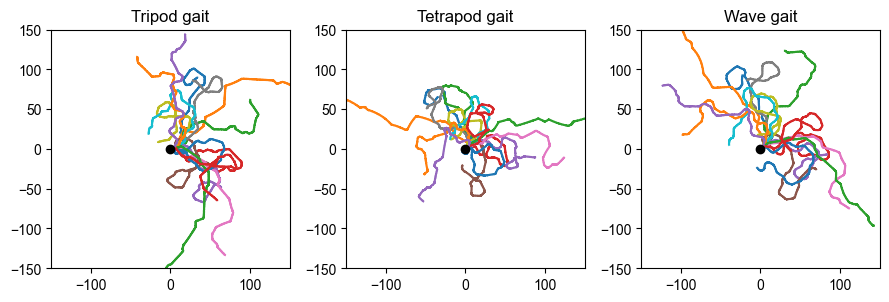

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
for gait, ax in zip(gaits, axs):
    for seed in range(num_trials_per_gait):
        fly_pos = trial_data[(gait, seed)]["fly_pos"]
        ax.plot(fly_pos[:, 0], fly_pos[:, 1], alpha=1)
    ax.plot([0], [0], "o", color="black")
    ax.set_title(f"{gait.title()} gait")
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    ax.set_aspect("equal")

## Extract input/output variables and train models

In [7]:
def get_leg_mask(legs: str) -> np.ndarray:
    legs = legs.upper()
    leg_mask = np.zeros(3, dtype=bool)
    if "F" in legs:
        leg_mask[0] = True
    if "M" in legs:
        leg_mask[1] = True
    if "H" in legs:
        leg_mask[2] = True
    return leg_mask


def extract_variables(
    trial_data: Dict[str, np.ndarray],
    time_scale: float,
    contact_force_thr: float,
    legs: str,
    dt: float = 1e-4,
) -> Dict[str, np.ndarray]:
    window_len = int(time_scale / dt)

    # Proprioceptive signal ==========
    # Calculate total stride (Σstride) for each side
    stride_left = trial_data["end_effector_pos"][:, :3, 0]
    stride_right = trial_data["end_effector_pos"][:, 3:, 0]
    contact_mask = trial_data["contact_force"] > contact_force_thr  # (L, 6)
    leg_mask = get_leg_mask(legs)
    stride_left = (stride_left * contact_mask[:, :3])[:, leg_mask]
    stride_right = (stride_right * contact_mask[:, 3:])[:, leg_mask]
    stride_total_left = np.cumsum(stride_left, axis=0)
    stride_total_right = np.cumsum(stride_right, axis=0)

    # Calculate difference in Σstride over proprioceptive time window (ΔΣstride)
    stride_total_diff_left = (
        stride_total_left[window_len:] - stride_total_left[:-window_len]
    )
    stride_total_diff_right = (
        stride_total_right[window_len:] - stride_total_right[:-window_len]
    )

    # Calculate sum and difference in ΔΣstride over two sides
    stride_total_diff_lrsum = stride_total_diff_left + stride_total_diff_right
    stride_total_diff_lrdiff = stride_total_diff_left - stride_total_diff_right

    # Descending signal ==========
    # Calculate mean DN drive over proprioceptive time window
    dn_drive = trial_data["dn_drive"]
    conv_kernel = np.ones(window_len)[:, None] / window_len  # (window_len, 1)
    mean_dn_drive = convolve2d(dn_drive, conv_kernel, mode="valid")[1:, :]

    # Same for left-right sum and difference
    sum_dn_drive = mean_dn_drive[:, 0] + mean_dn_drive[:, 1]
    diff_dn_drive = mean_dn_drive[:, 0] - mean_dn_drive[:, 1]

    # Change in locomotion state (heading & displacement) ==========
    # Calculate change in fly orientation over proprioceptive time window (Δheading)
    fly_orientation_xy = trial_data["fly_orientation"]
    heading_ts = np.arctan2(fly_orientation_xy[:, 1], fly_orientation_xy[:, 0])
    heading_diff = heading_ts[window_len:] - heading_ts[:-window_len]
    heading_diff = (heading_diff + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, π]

    # Same for displacement projected in the direction of fly's heading
    # Use projection formula: proj_v(u) = (u · v) / (v · v) * v where v is the fly's
    # heading vector and u is the change in position
    fly_disp_xy = np.diff(trial_data["fly_pos"], axis=0, prepend=0)
    fly_orientation_xy_norm = np.linalg.norm(fly_orientation_xy, axis=1)
    fly_orientation_xy_unit = fly_orientation_xy / fly_orientation_xy_norm[:, None]
    udotv = np.sum(fly_disp_xy * fly_orientation_xy_unit, axis=1)
    vdotv = np.sum(fly_orientation_xy_unit * fly_orientation_xy_unit, axis=1)
    forward_disp_mag = udotv / vdotv
    forward_disp_total = np.cumsum(forward_disp_mag)
    forward_disp_total_diff = (
        forward_disp_total[window_len:] - forward_disp_total[:-window_len]
    )

    return {
        "stride_total_diff_lrsum": stride_total_diff_lrsum.astype(np.float32),
        "stride_total_diff_lrdiff": stride_total_diff_lrdiff.astype(np.float32),
        "sum_dn_drive": sum_dn_drive.astype(np.float32)[:, None],
        "diff_dn_drive": diff_dn_drive.astype(np.float32)[:, None],
        "heading_diff": heading_diff.astype(np.float32),
        "forward_disp_total_diff": forward_disp_total_diff.astype(np.float32),
    }

In [8]:
def fit_1d_linear_model(x: np.ndarray, y: np.ndarray) -> Tuple[float, float, float]:
    model = LinearRegression()
    model.fit(x, y)
    r2 = model.score(x, y)
    return model.coef_, model.intercept_, r2


def model_info_to_dict(
    model_info: Tuple[float, float, float], model_name: str, legs: str
) -> Dict[str, float]:
    coefs, intercept, r2 = model_info
    leg_mask = get_leg_mask(legs)
    coefs_all = np.full(3, np.nan)
    coefs_all[leg_mask] = coefs
    return {
        f"k_fore_{model_name}": coefs_all[0],
        f"k_mid_{model_name}": coefs_all[1],
        f"k_hind_{model_name}": coefs_all[2],
        f"b_{model_name}": intercept,
        f"r2_{model_name}": r2,
    }


def fit_models(
    trial_data: Dict[str, np.ndarray],
    time_scale: float,
    contact_force_thr: float,
    legs: str,
    dt: float = 1e-4,
):
    variables = extract_variables(trial_data, time_scale, contact_force_thr, legs, dt)
    model_info = {}

    model_prop2heading = fit_1d_linear_model(
        variables["stride_total_diff_lrdiff"], variables["heading_diff"]
    )
    model_info.update(model_info_to_dict(model_prop2heading, "prop2heading", legs))

    model_prop2disp = fit_1d_linear_model(
        variables["stride_total_diff_lrsum"], variables["forward_disp_total_diff"]
    )
    model_info.update(model_info_to_dict(model_prop2disp, "prop2disp", legs))

    model_dn2heading = fit_1d_linear_model(
        variables["diff_dn_drive"], variables["heading_diff"]
    )
    model_info.update(model_info_to_dict(model_dn2heading, "dn2heading", legs))

    model_dn2disp = fit_1d_linear_model(
        variables["sum_dn_drive"], variables["forward_disp_total_diff"]
    )
    model_info.update(model_info_to_dict(model_dn2disp, "dn2disp", legs))

    return model_info

Let's inspect what it looks like roughly

In [9]:
variables = extract_variables(
    trial_data=trial_data[("tripod", 0)],
    time_scale=0.64,
    contact_force_thr=3,
    legs="FMH",
)

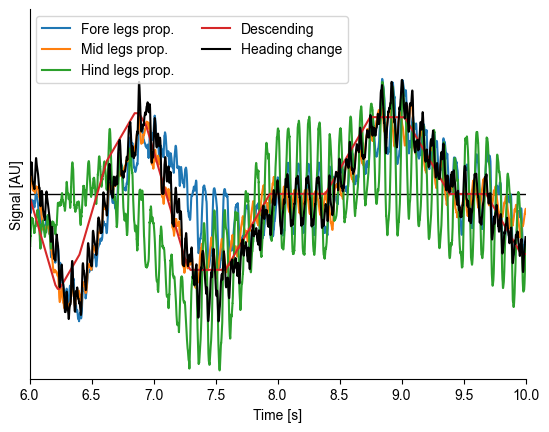

In [10]:
# scale some variables just so they look visually aligned
t_grid = np.arange(variables["heading_diff"].shape[0]) * 1e-4 + 0.64
plt.axhline(0, color="black", lw=1)
plt.plot(
    t_grid, variables["stride_total_diff_lrdiff"][:, 0] * 0.4, label="Fore legs prop."
)
plt.plot(
    t_grid, variables["stride_total_diff_lrdiff"][:, 1] * 0.2, label="Mid legs prop."
)
plt.plot(
    t_grid, variables["stride_total_diff_lrdiff"][:, 2] * 0.5, label="Hind legs prop."
)
plt.plot(t_grid, variables["diff_dn_drive"] * -0.8, label="Descending")
plt.plot(t_grid, variables["heading_diff"] * 1, color="black", label="Heading change")
plt.xlim(6, 10)
plt.yticks([])
plt.ylim(-1.3, 1.3)
plt.xlabel("Time [s]")
plt.ylabel("Signal [AU]")
plt.legend(ncol=2)
sns.despine()

And now, let's fit models properly

In [11]:
fit_models(
    trial_data=trial_data[("tripod", 0)],
    time_scale=0.64,
    contact_force_thr=3,
    legs="FMH",
)

{'k_fore_prop2heading': 0.22477424144744873,
 'k_mid_prop2heading': 0.12876902520656586,
 'k_hind_prop2heading': 0.02407325617969036,
 'b_prop2heading': 0.015173078,
 'r2_prop2heading': 0.9314782925661186,
 'k_fore_prop2disp': -0.446598082780838,
 'k_mid_prop2disp': -0.23484736680984497,
 'k_hind_prop2disp': -0.21717578172683716,
 'b_prop2disp': 1.5451183,
 'r2_prop2disp': 0.9700852831092881,
 'k_fore_dn2heading': -0.991254985332489,
 'k_mid_dn2heading': -0.991254985332489,
 'k_hind_dn2heading': -0.991254985332489,
 'b_dn2heading': 0.027813062,
 'r2_dn2heading': 0.8791487533887189,
 'k_fore_dn2disp': 4.576233386993408,
 'k_mid_dn2disp': 4.576233386993408,
 'k_hind_dn2disp': 4.576233386993408,
 'b_dn2disp': -0.56313324,
 'r2_dn2disp': 0.9370220226742878}

Let's fit a lot of models with different parameters to do a sensitivity analysis. We will do it in parallel because there are lots of models.

In [12]:
trial_variables = {}
time_scales = [0.01, 0.04, 0.16, 0.64, 2.56]
contact_force_thresholds = [2, 3, 4, 5, 6, 7]
trials = list(range(10))  # use only the first 5 trials for training
configs = list(
    itertools.product(gaits, trials, time_scales, contact_force_thresholds, ["FMH"])
)


def wrapper(config):
    gait, seed, time_scale, contact_force_thr, legs = config
    model_info = fit_models(
        trial_data[(gait, seed)], time_scale, contact_force_thr, legs
    )
    model_info["gait"] = gait
    model_info["seed"] = seed
    model_info["time_scale"] = time_scale
    model_info["contact_force_thr"] = contact_force_thr
    model_info["legs"] = legs
    return model_info


with Pool(15) as pool:
    results = list(tqdm(pool.imap(wrapper, configs), total=len(configs)))

model_df1 = pd.DataFrame(results)
model_df1 = model_df1.set_index(
    ["gait", "seed", "time_scale", "contact_force_thr", "legs"]
)
model_df1.to_pickle(model_basedir / "model_df_sensitivity_analysis_1.pkl")

100%|██████████| 900/900 [15:33<00:00,  1.04s/it] 


Let's check the result of this rough sensitivity analysis

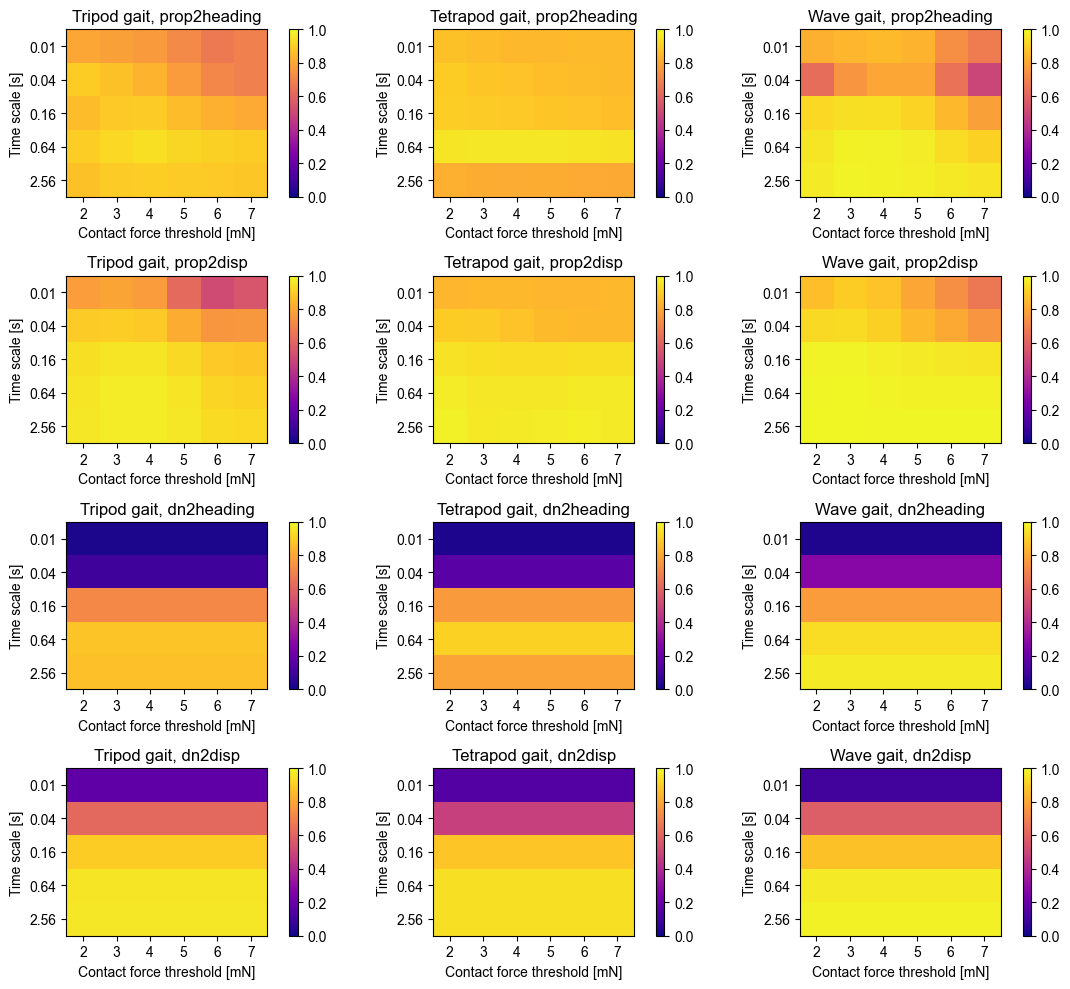

In [13]:
metrics = ["r2_prop2heading", "r2_prop2disp", "r2_dn2heading", "r2_dn2disp"]
fig, axs = plt.subplots(4, 3, figsize=(12, 10), tight_layout=True)
for row, metric in enumerate(metrics):
    for col, gait in enumerate(gaits):
        ax = axs[row, col]
        perf_mat = np.full((len(time_scales), len(contact_force_thresholds)), np.nan)
        for i, time_scale in enumerate(time_scales):
            for j, contact_force_thr in enumerate(contact_force_thresholds):
                sel = model_df1.loc[gait, :, time_scale, contact_force_thr]
                perf_mat[i, j] = sel[metric].mean()
        cax = ax.matshow(perf_mat, cmap="plasma", vmin=0, vmax=1)
        fig.colorbar(cax)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xticks(np.arange(len(contact_force_thresholds)))
        ax.set_xticklabels(contact_force_thresholds)
        ax.set_yticks(np.arange(len(time_scales)))
        ax.set_yticklabels(time_scales)
        ax.set_xlabel("Contact force threshold [mN]")
        ax.set_ylabel("Time scale [s]")
        ax.set_title(f"{gait.title()} gait, {metric.replace('r2_', '')}")
fig.savefig(model_basedir / "sensitivity_analysis_1.pdf")

Let's do another sensitivity analysis, this time just focusing on the time scale

In [14]:
trial_variables = {}
time_scales = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12]
# legs_combi = ["F", "M", "H", "FM", "FH", "MH", "FMH"]
trials = list(range(10))  # use only the first 5 trials for training
configs = list(itertools.product(gaits, trials, time_scales, [3], ["FMH"]))


def wrapper(config):
    gait, seed, time_scale, contact_force_thr, legs = config
    model_info = fit_models(
        trial_data[(gait, seed)], time_scale, contact_force_thr, legs
    )
    model_info["gait"] = gait
    model_info["seed"] = seed
    model_info["time_scale"] = time_scale
    model_info["contact_force_thr"] = contact_force_thr
    model_info["legs"] = legs
    return model_info


with Pool(15) as pool:
    results = list(tqdm(pool.imap(wrapper, configs), total=len(configs)))

model_df2 = pd.DataFrame(results)
model_df2 = model_df2.set_index(
    ["gait", "seed", "time_scale", "contact_force_thr", "legs"]
)
model_df2.to_pickle(model_basedir / "model_df_sensitivity_analysis_2.pkl")

100%|██████████| 300/300 [07:23<00:00,  1.48s/it] 


In [15]:
model_df2

k_fore_prop2heading  \
gait   seed time_scale contact_force_thr legs                        
tripod 0    0.01       3                 FMH              0.266622   
            0.02       3                 FMH              0.262244   
            0.04       3                 FMH              0.236640   
            0.08       3                 FMH              0.237498   
            0.16       3                 FMH              0.240234   
...                                                            ...   
wave   9    0.32       3                 FMH              0.175143   
            0.64       3                 FMH              0.224208   
            1.28       3                 FMH              0.257710   
            2.56       3                 FMH              0.282492   
            5.12       3                 FMH              0.306360   

                                               k_mid_prop2heading  \
gait   seed time_scale contact_force_thr legs                       
tripod 0    0.01       3                 FMH             0.223081   
            0.02       3                 FMH             0.224992   
            0.04       3                 FMH             0.203272   
            0.08       3                 FMH             0.116326   
            0.16       3                 FMH             0.116375   
...                                                           ...   
wave   9    0.32       3                 FMH             0.188426   
            0.64       3                 FMH             0.158403   
            1.28       3                 FMH             0.141437   
            2.56       3                 FMH             0.117706   
            5.12       3                 FMH             0.115253   

                                               k_hind_prop2heading  \
gait   seed time_scale contact_force_thr legs                        
tripod 0    0.01       3                 FMH             -0.000767   
            0.02       3                 FMH             -0.017714   
            0.04       3                 FMH             -0.014068   
            0.08       3                 FMH              0.028200   
            0.16       3                 FMH              0.028272   
...                                                            ...   
wave   9    0.32       3                 FMH              0.100860   
            0.64       3                 FMH              0.111129   
            1.28       3                 FMH              0.118605   
            2.56       3                 FMH              0.136415   
            5.12       3                 FMH              0.128341   

                                               b_prop2heading  \
gait   seed time_scale contact_force_thr legs                   
tripod 0    0.01       3                 FMH        -0.001523   
            0.02       3                 FMH        -0.003142   
            0.04       3                 FMH        -0.004345   
            0.08       3                 FMH         0.002303   
            0.16       3                 FMH         0.004415   
...                                                       ...   
wave   9    0.32       3                 FMH         0.008048   
            0.64       3                 FMH         0.016539   
            1.28       3                 FMH         0.035155   
            2.56       3                 FMH         0.090436   
            5.12       3                 FMH         0.184629   

                                               r2_prop2heading  \
gait   seed time_scale contact_force_thr legs                    
tripod 0    0.01       3                 FMH          0.783812   
            0.02       3                 FMH          0.821178   
            0.04       3                 FMH          0.861338   
            0.08       3                 FMH          0.872595   
            0.16       3                 FMH          0.892953   
...                

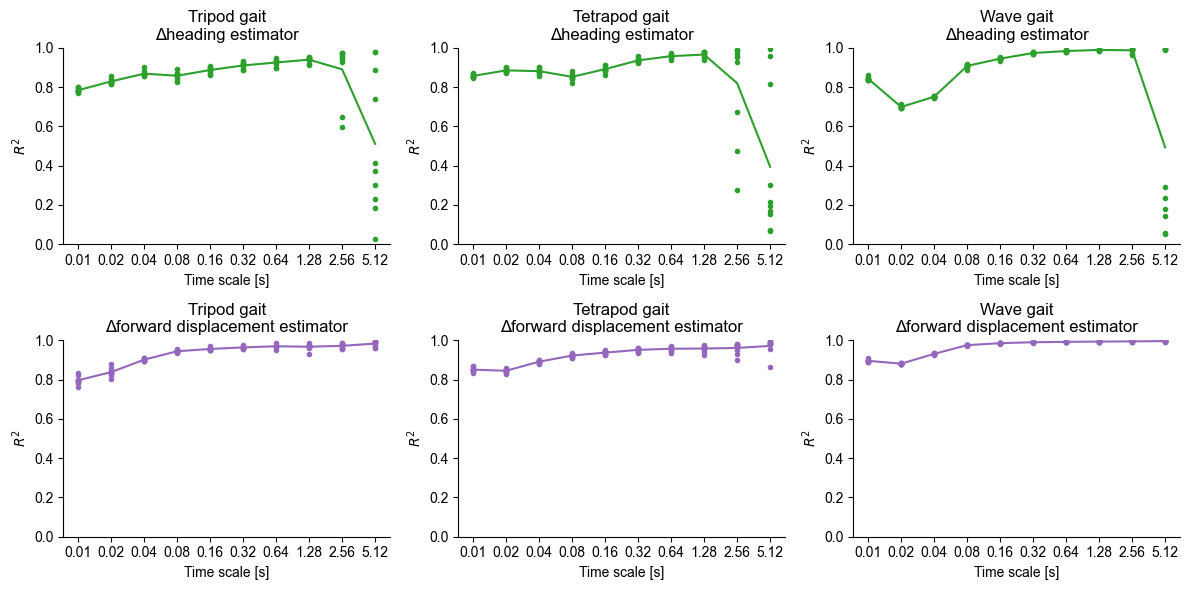

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
metric_configs = {
    "r2_prop2heading": ("Δheading estimator", "tab:green"),
    "r2_prop2disp": ("Δforward displacement estimator", "tab:purple"),
}
for col, gait in enumerate(gaits):
    for row, (metric, (title, color)) in enumerate(metric_configs.items()):
        ax = axs[row, col]
        mean_r2s = []
        for i, time_scale in enumerate(time_scales):
            sel = model_df2.loc[gait, :, time_scale, 3]
            ax.plot([i] * len(sel), sel[metric], ".", color=color)
            # ns.stripplot(x=[i] * len(sel), y=sel[metric], color=color, ax=ax)
            mean_r2s.append(sel[metric].mean())
        ax.plot(range(len(time_scales)), mean_r2s, label=title, color=color)
        ax.set_xticks(range(len(time_scales)))
        ax.set_xticklabels(time_scales)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Time scale [s]")
        ax.set_ylabel(f"$R^2$")
        ax.set_title(f"{gait.title()} gait\n{title}")
        sns.despine(ax=ax)
fig.savefig(model_basedir / "sensitivity_analysis_2.pdf")

Finally, let's check which legs provide the most information for path integration

In [17]:
trial_variables = {}
legs_combi = ["F", "M", "H", "FM", "FH", "MH", "FMH"]
trials = list(range(10))  # use only the first 5 trials for training
configs = list(itertools.product(gaits, trials, [0.64], [3], legs_combi))


def wrapper(config):
    gait, seed, time_scale, contact_force_thr, legs = config
    model_info = fit_models(
        trial_data[(gait, seed)], time_scale, contact_force_thr, legs
    )
    model_info["gait"] = gait
    model_info["seed"] = seed
    model_info["time_scale"] = time_scale
    model_info["contact_force_thr"] = contact_force_thr
    model_info["legs"] = legs
    return model_info


with Pool(15) as pool:
    results = list(tqdm(pool.imap(wrapper, configs), total=len(configs)))

model_df3 = pd.DataFrame(results)
model_df3 = model_df3.set_index(
    ["gait", "seed", "time_scale", "contact_force_thr", "legs"]
)
model_df3.to_pickle(model_basedir / "model_df_sensitivity_analysis_3.pkl")

100%|██████████| 210/210 [03:36<00:00,  1.03s/it]


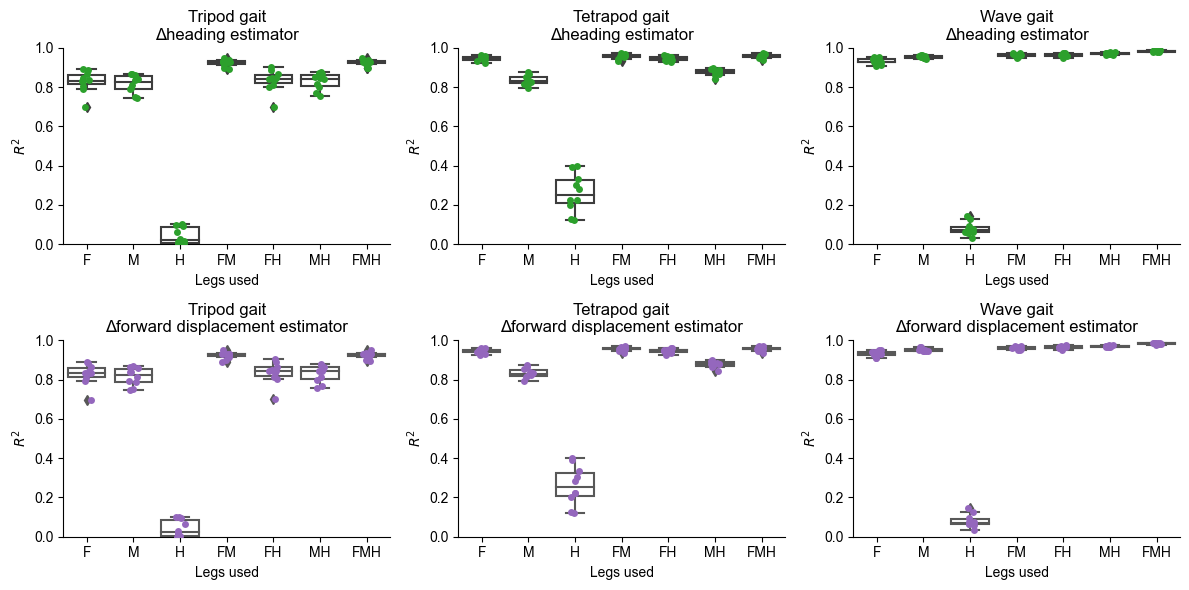

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
metric_configs = {
    "r2_prop2heading": ("Δheading estimator", "tab:green"),
    "r2_prop2disp": ("Δforward displacement estimator", "tab:purple"),
}
for col, gait in enumerate(gaits):
    for row, (metric, (title, color)) in enumerate(metric_configs.items()):
        ax = axs[row, col]
        sns.boxplot(
            data=model_df3.loc[gait, :, :, :, :].reset_index(),
            x="legs",
            y="r2_prop2heading",
            color=color,
            boxprops=dict(facecolor="none"),
            ax=ax,
        )
        sns.stripplot(
            data=model_df3.loc[gait, :, :, :, :],
            x="legs",
            y="r2_prop2heading",
            color=color,
            ax=ax,
        )
        ax.set_ylim(0, 1)
        ax.set_xlabel("Legs used")
        ax.set_ylabel(f"$R^2$")
        ax.set_title(f"{gait.title()} gait\n{title}")
        sns.despine(ax=ax)
fig.savefig(model_basedir / "sensitivity_analysis_3.pdf")

## Demonstrate final model

It looks like the best model parameters are the following:
- Contact force threshold: 3mN
- Time scale: 0.64s
- Legs: forelegs and midlegs

Let's use this model to perform path integration. We will do it on the 5 trials that we did *not* use to train the models.

First, let's build an ensemble model of the 10 trained models. Since the models are linear, we can simply average the weights and biases.

In [19]:
ensemble_models_df = model_df3.groupby(
    ["gait", "time_scale", "contact_force_thr", "legs"]
).mean()
ensemble_models_df.to_pickle(model_basedir / "ensemble_models_df.pkl")

In [20]:
ensemble_models_df

k_fore_prop2heading  \
gait     time_scale contact_force_thr legs                        
tetrapod 0.64       3                 F                0.250155   
                                      FH               0.248071   
                                      FM               0.199589   
                                      FMH              0.186324   
                                      H                     NaN   
                                      M                     NaN   
                                      MH                    NaN   
tripod   0.64       3                 F                0.424102   
                                      FH               0.430365   
                                      FM               0.243634   
                                      FMH              0.242558   
                                      H                     NaN   
                                      M                     NaN   
                                      MH                    NaN   
wave     0.64       3                 F                0.480627   
                                      FH               0.471830   
                                      FM               0.170608   
                                      FMH              0.216833   
                                      H                     NaN   
                                      M                     NaN   
                                      MH                    NaN   

                                            k_mid_prop2heading  \
gait     time_scale contact_force_thr legs                       
tetrapod 0.64       3                 F                    NaN   
                                      FH                   NaN   
                                      FM              0.057923   
                                      FMH             0.065192   
                                      H                    NaN   
                                      M               0.238986   
                                      MH              0.219013   
tripod   0.64       3                 F                    NaN   
                                      FH                   NaN   
                                      FM              0.124655   
                                      FMH             0.124785   
                                      H                    NaN   
                                      M               0.230210   
                                      MH              0.229613   
wave     0.64       3                 F                    NaN   
                                      FH                   NaN   
                                      FM              0.198197   
                                      FMH             0.163710   
                                      H                    NaN   
                                      M               0.299542   
                                      MH              0.293483   

                                            k_hind_prop2heading  \
gait     time_scale contact_force_thr legs                        
tetrapod 0.64       3                 F                     NaN   
                                      FH              -0.010710   
                                      FM                    NaN   
                                      FMH             -0.035786   
                                      H               -0.343762   
                                      M                     NaN   
                                      MH              -0.148859   
tripod   0.64       3                 F                     NaN   
                                      FH              -0.053382   
                                      FM                    NaN   
                                      FMH              0.001308   
                                      H                0.090655   
                                      M      

In [21]:
def path_integrate(
    trial_data: Dict[str, np.ndarray],
    heading_model: Callable,
    displacement_model: Callable,
    time_scale: float,
    contact_force_thr: float,
    legs: str,
    dt: float,
):
    window_len = int(time_scale / dt)
    variables = extract_variables(
        trial_data,
        time_scale=time_scale,
        contact_force_thr=contact_force_thr,
        legs=legs,
    )

    # Integrate heading
    heading_diff_pred = heading_model(variables["stride_total_diff_lrdiff"])
    heading_pred = np.cumsum(heading_diff_pred / window_len)
    # Path int. not performed when not enough data is available. Start from the real
    # heading at the moment when path int. actually starts.
    hx_start, hy_start = trial_data["fly_orientation"][window_len, :]
    real_heading_start = np.arctan2(hy_start, hx_start)
    heading_pred += real_heading_start

    # Integrate displacement
    displacement_diff_pred = displacement_model(variables["stride_total_diff_lrsum"])
    displacement_diff_x_pred = np.cos(heading_pred) * displacement_diff_pred
    displacement_diff_y_pred = np.sin(heading_pred) * displacement_diff_pred
    pos_x_pred = np.cumsum(displacement_diff_x_pred / window_len)
    pos_y_pred = np.cumsum(displacement_diff_y_pred / window_len)
    pos_pred = np.concatenate([pos_x_pred[:, None], pos_y_pred[:, None]], axis=1)

    # Pad with NaN where prediction not available
    heading_pred = np.concatenate([np.full(window_len, np.nan), heading_pred])
    pos_pred = np.concatenate([np.full((window_len, 2), np.nan), pos_pred], axis=0)

    return heading_pred, pos_pred

Processing wave gait: 100%|██████████| 5/5 [00:38<00:00,  7.61s/it]


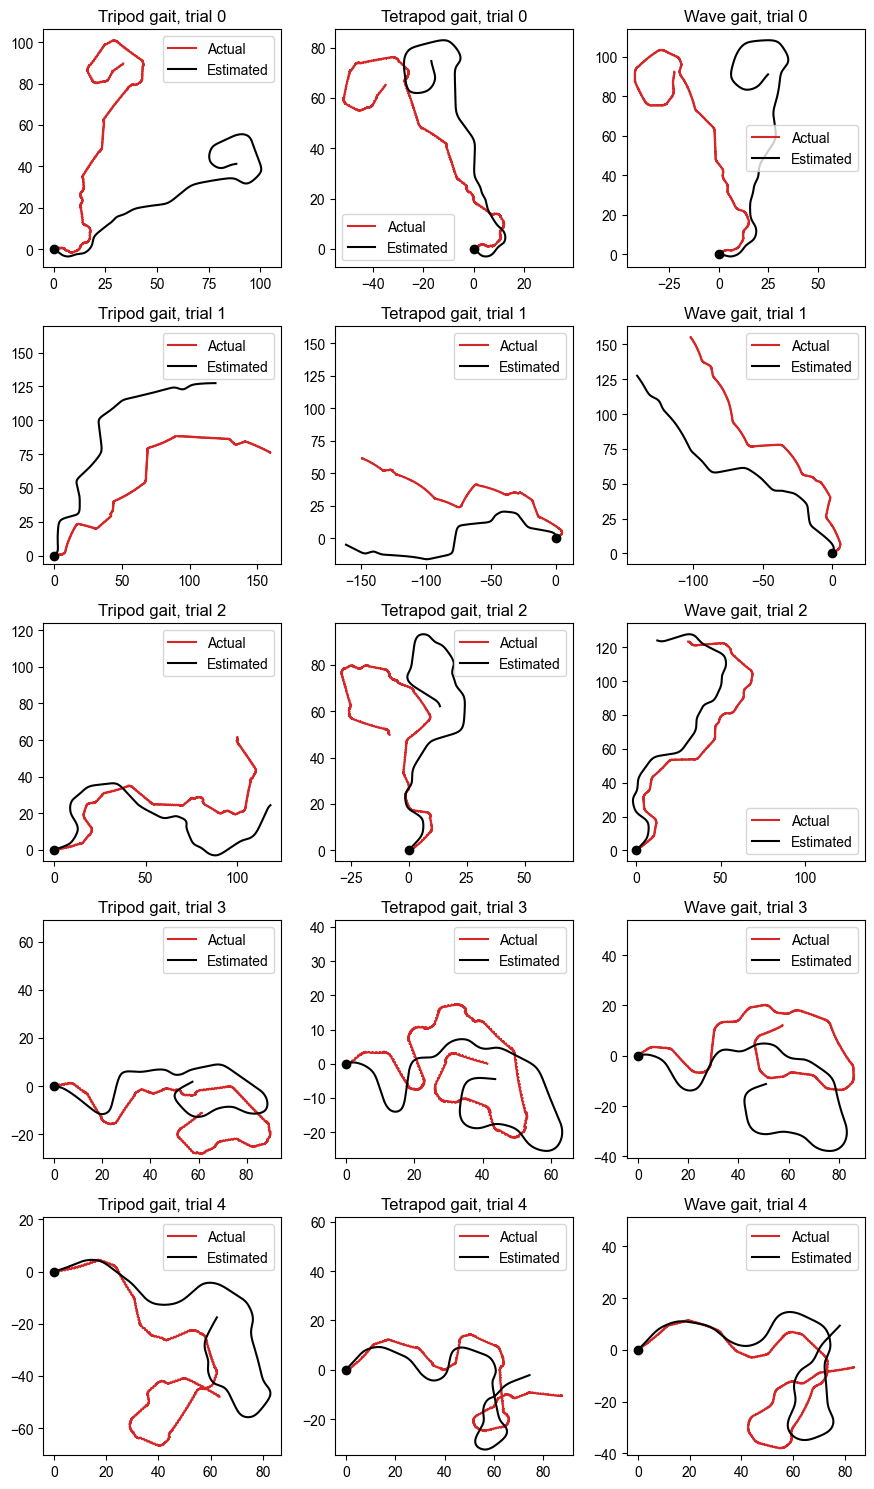

In [22]:
class LinearModel:
    def __init__(self, coefs_all, intercept, legs):
        self.coefs = coefs_all[get_leg_mask(legs)][None, :]
        self.intercept = intercept

    def __call__(self, x):
        return (x * self.coefs).sum(axis=1) + self.intercept


legs = "FMH"
contact_force_thr = 3
time_scale = 0.64


fig, axs = plt.subplots(5, 3, figsize=(9, 15), tight_layout=True)
for col, gait in enumerate(gaits):
    for row, seed in enumerate(trange(0, 5, desc=f"Processing {gait} gait")):
        ax = axs[row, col]
        model_info = ensemble_models_df.loc[gait, time_scale, contact_force_thr, legs]
        prop2heading_coefs = model_info[
            [f"k_{leg}_prop2heading" for leg in ["fore", "mid", "hind"]]
        ].values
        heading_model = LinearModel(
            prop2heading_coefs, model_info["b_prop2heading"], legs
        )
        prop2disp_coefs = model_info[
            [f"k_{leg}_prop2disp" for leg in ["fore", "mid", "hind"]]
        ].values
        disp_model = LinearModel(prop2disp_coefs, model_info["b_prop2disp"], legs)

        heading_pred, pos_pred = path_integrate(
            trial_data[(gait, seed)],
            heading_model,
            disp_model,
            time_scale=time_scale,
            contact_force_thr=contact_force_thr,
            legs=legs,
            dt=1e-4,
        )
        pos_real = trial_data[(gait, seed)]["fly_pos"]
        ax.plot(pos_real[:, 0], pos_real[:, 1], color="tab:red", label="Actual")
        ax.plot(pos_pred[:, 0], pos_pred[:, 1], color="black", label="Estimated")
        ax.plot([0], [0], "o", color="black")
        ax.set_title(f"{gait.title()} gait, trial {seed}")
        # ax.set_xlim(-150, 150)
        # ax.set_ylim(-150, 150)
        ax.axis("square")
        ax.set_aspect("equal")
        ax.legend()
fig.savefig(model_basedir / "path_integration.pdf")